In [ ]:
#Imports
import os
from fastai.vision.all import *
set_seed(42)

c:\Users\Geetansh\Desktop\Life\Mlvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Paths to train /validation /test sets

In [3]:
trn_path = r"./dataset/trainVal"
# val_path = r"./dataset/validate" #empty
test_path = r"./dataset/test"

### Start Training

(3264, 2448)


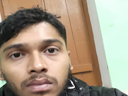

In [5]:
files = get_image_files(trn_path)
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

### Try 1 : No Normalization

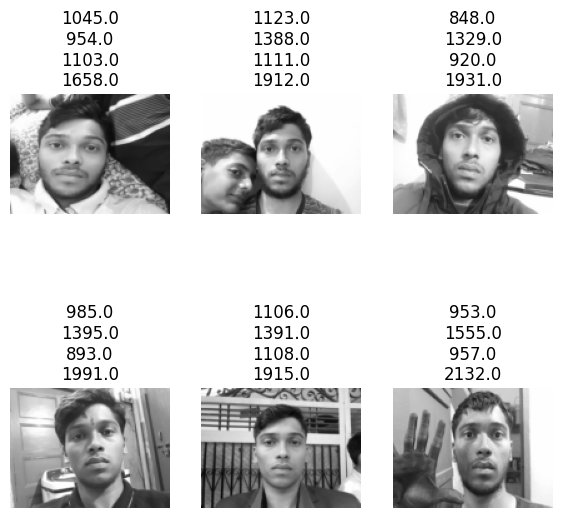

In [36]:
class GrayscaleTransform(Transform):
    def encodes(self, x:TensorImage):
        if x.shape[1] == 3:
            # Convert to grayscale - ensure output is truly monochromatic
            gray = 0.2989 * x[:,0] + 0.5870 * x[:,1] + 0.1140 * x[:,2]
            gray = gray.unsqueeze(1)
            # Replicate the single channel to 3 channels to maintain compatibility
            return gray.repeat(1, 3, 1, 1)
        return x

# Function to extract labels from the filenames
# def get_labels(file_path):
#     # Extract numbers after the first underscore
#     file_path = str(file_path)
#     file_path = file_path[0:-4]  # Get filename without extension
#     parts = file_path.split("_")[1:]  # Skip the first part (ID)
#     return list(map(float, parts))  # Convert to floats

def get_leftEyeR(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[1])  # Skip the first part (ID)

def get_leftEyeC(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[2])  # Skip the first part (ID)

def get_rightEyeR(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[3])  # Skip the first part (ID)

def get_rightEyeC(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[4])  # Skip the first part (ID)

# print(get_rightEyeR(r"./dataset/train/25_1134_1801_1127_2382.jpg"))

# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock, RegressionBlock, RegressionBlock, RegressionBlock),
    n_inp=1,
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=[get_leftEyeR, get_leftEyeC, get_rightEyeR, get_rightEyeC],  # Function to extract labels
    item_tfms=[RatioResize(max_sz=128)],
    batch_tfms=[GrayscaleTransform()]
)

#Create the DataLoaders
dls = dblock.dataloaders(trn_path, bs=20)  # Adjust batch size as needed

# # Visualize a batch
dls.show_batch(max_n=6, figsize=(7, 7))

In [38]:
def MSELossFlat(input, target):
    return ((input - target)**2).mean()

def leftEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    return MSELossFlat(input_from_model[:,0], leftEyeR) + MSELossFlat(input_from_model[:,1], leftEyeC)

def rightEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    return MSELossFlat(input_from_model[:,2], rightEyeR) + MSELossFlat(input_from_model[:,3], rightEyeC)

def net_Loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    # print("A: ", leftEyeR)
    # print("B: ", leftEyeR.shape)
    # print("C:", input_from_model)
    # print("D:", input_from_model.shape)
    # print("E:", input_from_model[:,0])
    # print("F:", input_from_model[:,0].shape)
    return leftEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC) + rightEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC)

# architecture = 'convnext_small_in22k' #Best Validation MSE : 5509446.000000 (10 epochs) (lr = 0.1)
# architecture = 'convnext_tiny_hnf' #Best Validation MSE : 327073 (10 epochs) (lr = 0.2)

learn = vision_learner(dls, architecture, loss_func=net_Loss, n_out=4).to_fp16()

c:\Users\Geetansh\Desktop\Life\Mlvenv\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Geetansh\.cache\huggingface\hub\models--timm--regnety_006.pycls_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


### Determine the learning rate (Hyperparameter tuning) (⚠: Expensive to run cell, don't run if in a hurry!)

c:\Users\Geetansh\Desktop\Life\Mlvenv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Geetansh\Desktop\Life\Mlvenv\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
c:\Users\Geetansh\Desktop\Life\Mlvenv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Geetansh\Desktop\Life\Mlvenv\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.war

c:\Users\Geetansh\Desktop\Life\Mlvenv\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **t

SuggestedLRs(valley=0.0691830962896347, slide=6.309573450380412e-07)

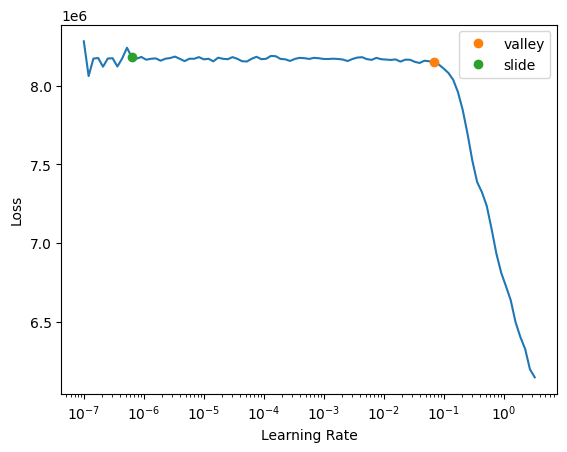

In [39]:
learn.lr_find(suggest_funcs=(valley, slide))

epoch,train_loss,valid_loss,time
0,8167220.000000,8833014.000000,00:10


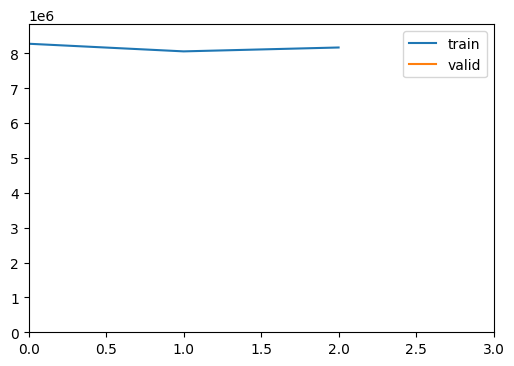

epoch,train_loss,valid_loss,time
0,8097117.000000,8799418.000000,00:11
1,8057975.000000,8662651.000000,00:11
2,7996784.500000,8412964.000000,00:11
3,7885117.500000,7827995.500000,00:10
4,7648663.500000,6495624.000000,00:10
5,7235590.000000,4287838.000000,00:10
6,6594780.500000,2115828.250000,00:10
7,5816001.500000,896754.062500,00:10
8,5084735.000000,684112.375000,00:10
9,4507972.500000,629631.125000,00:10


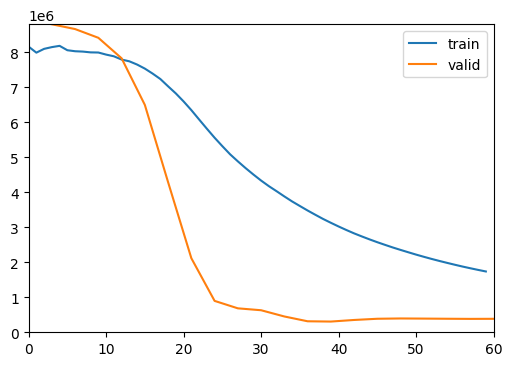

In [40]:
learn.fine_tune(20, 0.2, cbs=[
    ShowGraphCallback(),
]) #epochs and learning rate

### Try2: Now try Normalization

In [ ]:
class GrayscaleTransform(Transform):
    def encodes(self, x:TensorImage):
        if x.shape[1] == 3:
            # Convert to grayscale - ensure output is truly monochromatic
            gray = 0.2989 * x[:,0] + 0.5870 * x[:,1] + 0.1140 * x[:,2]
            gray = gray.unsqueeze(1)
            # Replicate the single channel to 3 channels to maintain compatibility
            return gray.repeat(1, 3, 1, 1)
        return x

# Function to extract labels from the filenames
# def get_labels(file_path):
#     # Extract numbers after the first underscore
#     file_path = str(file_path)
#     file_path = file_path[0:-4]  # Get filename without extension
#     parts = file_path.split("_")[1:]  # Skip the first part (ID)
#     return list(map(float, parts))  # Convert to floats

def get_leftEyeR(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[1])  # Skip the first part (ID)

def get_leftEyeC(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[2])  # Skip the first part (ID)

def get_rightEyeR(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[3])  # Skip the first part (ID)

def get_rightEyeC(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[4])  # Skip the first part (ID)

# print(get_rightEyeR(r"./dataset/train/25_1134_1801_1127_2382.jpg"))

# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock, RegressionBlock, RegressionBlock, RegressionBlock),
    n_inp=1,
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=[get_leftEyeR, get_leftEyeC, get_rightEyeR, get_rightEyeC],  # Function to extract labels
    item_tfms=[RatioResize(max_sz=128)],
    batch_tfms=[GrayscaleTransform()]
)

#Create the DataLoaders
dls = dblock.dataloaders(trn_path, bs=20)  # Adjust batch size as needed

# # Visualize a batch
dls.show_batch(max_n=6, figsize=(7, 7))

In [41]:
def MSELossFlat(input, target):
    return ((input - target)**2).mean()

def leftEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    return MSELossFlat(input_from_model[:,0], leftEyeR) + MSELossFlat(input_from_model[:,1], leftEyeC)

def rightEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    return MSELossFlat(input_from_model[:,2], rightEyeR) + MSELossFlat(input_from_model[:,3], rightEyeC)

def net_Loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    # print("A: ", leftEyeR)
    # print("B: ", leftEyeR.shape)
    # print("C:", input_from_model)
    # print("D:", input_from_model.shape)
    # print("E:", input_from_model[:,0])
    # print("F:", input_from_model[:,0].shape)
    #Normalization
    leftEyeR /= 2448
    rightEyeR /= 2448
    leftEyeC /= 3264
    rightEyeC /= 3264
    return leftEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC) + rightEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC)

# architecture = 'convnext_small_in22k' #Best Validation MSE : 5509446.000000 (10 epochs) (lr = 0.1)
# architecture = 'convnext_tiny_hnf' #Best Validation MSE : 327073 (10 epochs) (lr = 0.2)
architecture = 'regnety_006' #Best Validation MSE :  ( epochs) (lr = )

learn = vision_learner(dls, architecture, loss_func=net_Loss, n_out=4).to_fp16()

c:\Users\Geetansh\Desktop\Life\Mlvenv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Geetansh\Desktop\Life\Mlvenv\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
c:\Users\Geetansh\Desktop\Life\Mlvenv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Geetansh\Desktop\Life\Mlvenv\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.war

epoch,train_loss,valid_loss,time
0,40.507786,3623.647217,00:10


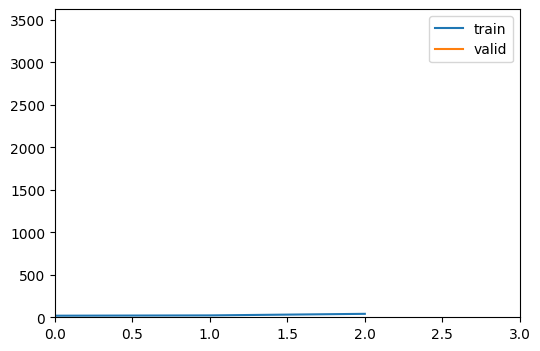

epoch,train_loss,valid_loss,time
0,73.451576,178.278671,00:11
1,63.430130,90.175415,00:11
2,52.432457,40.948284,00:11
3,46.458626,16.802286,00:11
4,43.164005,16.670416,00:11
5,39.840641,8.722472,00:10
6,37.757252,7.754982,00:10
7,35.448437,11.240464,00:10
8,32.854996,7.234338,00:10
9,31.191755,3.239782,00:10


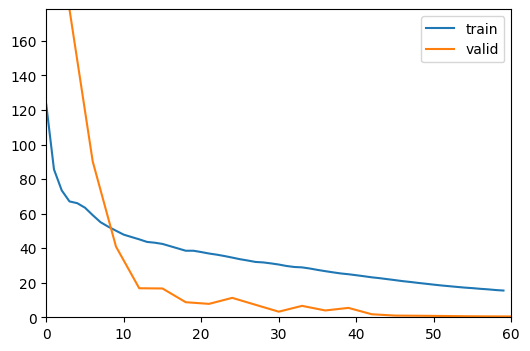

In [42]:
learn.fine_tune(20, 0.2, cbs=[
    ShowGraphCallback(),
]) #epochs and learning rate

### Try3 : With Increased image size, No greyscale

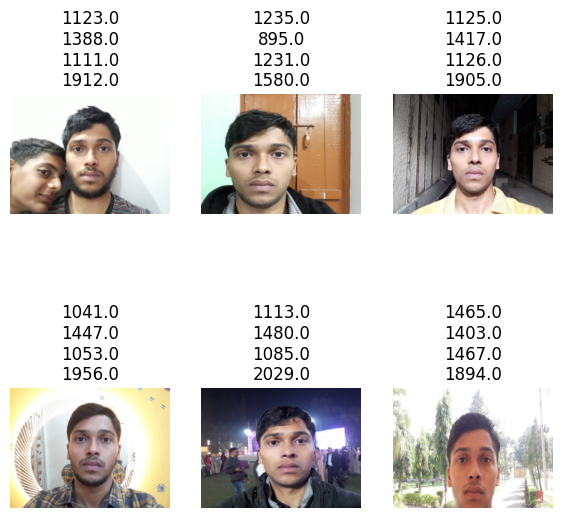

In [43]:
# Function to extract labels from the filenames
# def get_labels(file_path):
#     # Extract numbers after the first underscore
#     file_path = str(file_path)
#     file_path = file_path[0:-4]  # Get filename without extension
#     parts = file_path.split("_")[1:]  # Skip the first part (ID)
#     return list(map(float, parts))  # Convert to floats

def get_leftEyeR(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[1])  # Skip the first part (ID)

def get_leftEyeC(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[2])  # Skip the first part (ID)

def get_rightEyeR(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[3])  # Skip the first part (ID)

def get_rightEyeC(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[4])  # Skip the first part (ID)

# print(get_rightEyeR(r"./dataset/train/25_1134_1801_1127_2382.jpg"))

# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock, RegressionBlock, RegressionBlock, RegressionBlock),
    n_inp=1,
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=[get_leftEyeR, get_leftEyeC, get_rightEyeR, get_rightEyeC],  # Function to extract labels
    item_tfms=[RatioResize(max_sz=256)],
)

#Create the DataLoaders
dls = dblock.dataloaders(trn_path, bs=20)  # Adjust batch size as needed

# # Visualize a batch
dls.show_batch(max_n=6, figsize=(7, 7))

In [44]:
def MSELossFlat(input, target):
    return ((input - target)**2).mean()

def leftEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    return MSELossFlat(input_from_model[:,0], leftEyeR) + MSELossFlat(input_from_model[:,1], leftEyeC)

def rightEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    return MSELossFlat(input_from_model[:,2], rightEyeR) + MSELossFlat(input_from_model[:,3], rightEyeC)

def net_Loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    # print("A: ", leftEyeR)
    # print("B: ", leftEyeR.shape)
    # print("C:", input_from_model)
    # print("D:", input_from_model.shape)
    # print("E:", input_from_model[:,0])
    # print("F:", input_from_model[:,0].shape)
    #Normalization
    leftEyeR /= 2448
    rightEyeR /= 2448
    leftEyeC /= 3264
    rightEyeC /= 3264
    return leftEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC) + rightEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC)

# architecture = 'convnext_small_in22k' #Best Validation MSE : 5509446.000000 (10 epochs) (lr = 0.1)
# architecture = 'convnext_tiny_hnf' #Best Validation MSE : 327073 (10 epochs) (lr = 0.2)
architecture = 'regnety_006' #Best Validation MSE :  ( epochs) (lr = )

learn = vision_learner(dls, architecture, loss_func=net_Loss, n_out=4).to_fp16()

epoch,train_loss,valid_loss,time
0,44.112411,7542.241211,00:14


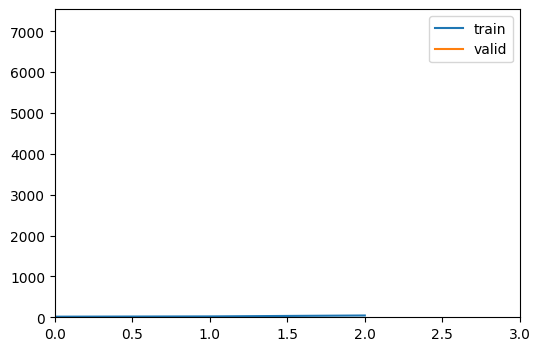

epoch,train_loss,valid_loss,time
0,95.820786,202.121094,00:14
1,71.649025,64.652878,00:14
2,59.716461,25.035601,00:13
3,50.943420,15.775892,00:13
4,45.636314,16.611500,00:13
5,43.274166,11.854150,00:13
6,39.780720,29.400463,00:13
7,36.437138,25.443060,00:13
8,33.422588,9.896641,00:13
9,31.124500,9.212075,00:13


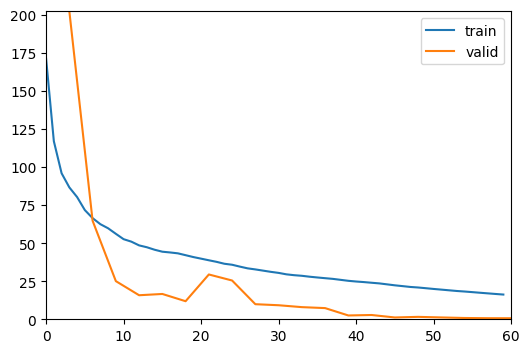

In [45]:
learn.fine_tune(20, 0.2, cbs=[
    ShowGraphCallback(),
]) #epochs and learning rate

### Try4 : Even bigger size RGB images 

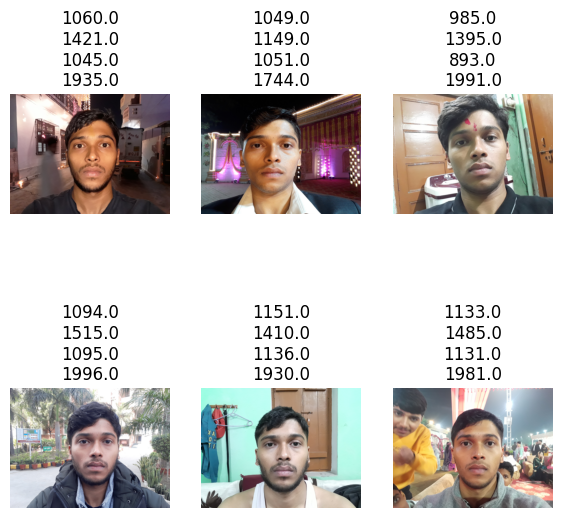

In [9]:
# Function to extract labels from the filenames
# def get_labels(file_path):
#     # Extract numbers after the first underscore
#     file_path = str(file_path)
#     file_path = file_path[0:-4]  # Get filename without extension
#     parts = file_path.split("_")[1:]  # Skip the first part (ID)
#     return list(map(float, parts))  # Convert to floats

def get_leftEyeR(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[1])  # Skip the first part (ID)

def get_leftEyeC(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[2])  # Skip the first part (ID)

def get_rightEyeR(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[3])  # Skip the first part (ID)

def get_rightEyeC(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[4])  # Skip the first part (ID)

# print(get_rightEyeR(r"./dataset/train/25_1134_1801_1127_2382.jpg"))

# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock, RegressionBlock, RegressionBlock, RegressionBlock),
    n_inp=1,
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=[get_leftEyeR, get_leftEyeC, get_rightEyeR, get_rightEyeC],  # Function to extract labels
    item_tfms=[RatioResize(max_sz=512)],
)

#Create the DataLoaders
dls = dblock.dataloaders(trn_path, bs=20)  # Adjust batch size as needed

# # Visualize a batch
dls.show_batch(max_n=6, figsize=(7, 7))

In [10]:
def MSELossFlat(input, target):
    return ((input - target)**2).mean()

def leftEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    return MSELossFlat(input_from_model[:,0], leftEyeR) + MSELossFlat(input_from_model[:,1], leftEyeC)

def rightEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    return MSELossFlat(input_from_model[:,2], rightEyeR) + MSELossFlat(input_from_model[:,3], rightEyeC)

def net_Loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    # print("A: ", leftEyeR)
    # print("B: ", leftEyeR.shape)
    # print("C:", input_from_model)
    # print("D:", input_from_model.shape)
    # print("E:", input_from_model[:,0])
    # print("F:", input_from_model[:,0].shape)
    #Normalization
    leftEyeR /= 2448
    rightEyeR /= 2448
    leftEyeC /= 3264
    rightEyeC /= 3264
    return leftEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC) + rightEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC)

# architecture = 'convnext_small_in22k' #Best Validation MSE : 5509446.000000 (10 epochs) (lr = 0.1)
# architecture = 'convnext_tiny_hnf' #Best Validation MSE : 327073 (10 epochs) (lr = 0.2)
architecture = 'regnety_006' #Best Validation MSE :  ( epochs) (lr = )

learn = vision_learner(dls, architecture, loss_func=net_Loss, n_out=4).to_fp16()

epoch,train_loss,valid_loss,time
0,69.956261,1163.064819,00:28


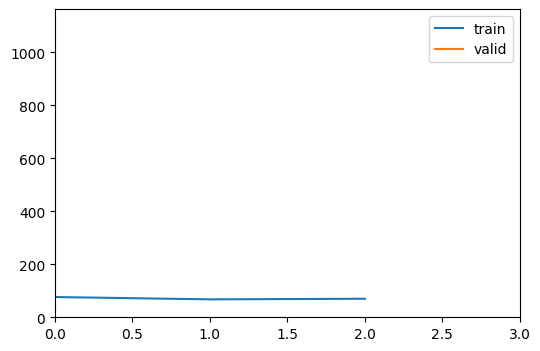

epoch,train_loss,valid_loss,time
0,58.155334,602.582947,00:31
1,61.167408,286.184967,00:33


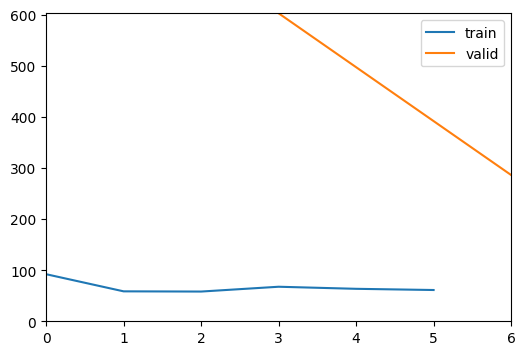

In [12]:
learn.fine_tune(2, 0.2, cbs=[
    ShowGraphCallback(),
]) #epochs and learning rate

### Export the model then load it and make inference

In [13]:
learn.export('./Dummymodel.pkl')

In [18]:
newLearn = load_learner("./Dummymodel.pkl")

In [20]:
img_path = r"dataset/trainVal/1_1081_1446_1069_1953.jpg"
# dl = newLearn.dls.test_dl([img_path])  # Create a DataLoader with the same transformations
# predictions = learn.get_preds(dl=dl)
# print(predictions)

a,b,c,d = newLearn.predict(img_path)

AssertionError: Match length mismatch

### Empty The GPU if you are using it!

In [7]:
import torch
print(torch.cuda.is_available())

torch.cuda.empty_cache()

False
